# Generate a PSF for SIXTE
In this notebook, I'm constructing PSF files for AXIS that can be used with SIXTE. My goal is to make the PSF look good, not to provide a physics-based simulation. At this point, we simply do not know enough about the mirrors to reliably predict the shape of the scattering wings and their energy dependence. Instead, this PSF should be seen as a "requirement" in the sense of "We want a PSF that looks like this or better". So, these PSFs are build up using our requirements on the PSF core and knowledge from Chandra on how the scattering wings due to microroughness of mirrors typically behave, without necessarily being correct in all aspects.

However, a realistically-looking PSF will be sufficient to analyze potential science cases; no science case depends on e.g. the exact energy dependence on the scattering wings.

Here, I chose to describe the PSF as a Voigt profile. This functional form has the Gaussian core we expect, but also wide wings that we see in all X-ray telescopes to date, e.g. Chandra. I select the parameters to be qualitatively similar to the Chandra PSF, but again, **the AXIS PSF will almost certainly not look exactly as described here. Still, my PSF here is more certainly more realistic than simply picking a Gaussian**.

In [1]:
import os
import re
from datetime import datetime
import urllib.request

import numpy as np
from scipy.special import voigt_profile
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt


In [2]:
import urllib.request

In [3]:
focallength = 9 * u.m

In [4]:
# Get the PDF form Thomas Dauser to inspect what the header keywords are etc. that SIXTE expects

# See later if I even need this file or make the new files form scratch, once I know how everything is called.
input_name = 'axis_psf_gauss_v3.fits'
# Download the file from `url` and save it locally under `file_name`:
if not os.path.exists(input_name):
    urllib.request.urlretrieve('http://www.sternwarte.uni-erlangen.de/~dauser/axis/psf/' + input_name,
                           input_name)

In [5]:
hdus = fits.open(input_name)

In [6]:
def image_voigt(n_pix, FWHM, gamma, pixel_per_arcsec=5):
    sigma = FWHM / 2.355
    # +0.5 to get to the center of a pixel and because FITS has origin at [1, 1], while numpy has at [0, 0]
    dx, dy = np.mgrid[0: n_pix, 0: n_pix]
    dx = dx - n_pix / 2. + 0.5
    dy = dy - n_pix / 2. + 0.5
    radius = np.sqrt(dx**2 + dy**2)
    arr = voigt_profile(radius, sigma * pixel_per_arcsec, gamma * pixel_per_arcsec)
    # +0.5 to get to the center of a pixel and because FITS has origin at [1, 1], while numpy has at [0, 0]
    #voigt = voigt_profile(np.arange(n_pix) - n_pix / 2. + 0.5, 
    #                      sigma * pixel_per_arcsec, 
    #                      gamma * pixel_per_arcsec)
    #arr = voigt[None, :] * voigt[:, None]
    arr = arr / arr.sum()
    return arr

In [7]:
arr = image_voigt(250, 1., 0.001)

## How do we want our PSF to look?
Initially, AXIS was based simply on the requirement on the FWHM of the PSF. With that, the easiest implementation is to assume a Gaussian. However, this is also the best case; in real mirrors we see much broader scattering wings caused by microroughness on the mirror surface. Here, I'm going to find a parameterization based on Chandra that can describe this behavior.

In [8]:
#plt.plot(hdus[0].data[125, :] / hdus[0].data[125, 125])
#plt.plot(arr[125, :])
#plt.xlabel('x [pixel in PSF file]')
#plt.title('Compare Thomas Dauser PSF with mine to check format')
#plt.xlim(105, 124.5)
#plt.grid(True)


In [9]:
tab = '''
#Photon Energy (keV)	Off-Axis Angle (arcmin)								
energies	0	2	4	6	8	10	12	14	16
0.2	1.00	1.00	1.01	1.02	1.06	1.14	1.46348	1.86108	2.48588
0.5	1.00	1.00	1.01	1.02	1.07	1.16	1.24003	1.44851	1.76552
2.0	1.00	1.00	1.01	1.04	1.09	1.21	1.3998	1.7968	2.4674
4.0	1.00	1.00	1.01	1.05	1.16	1.33	1.52896	1.76496	1.98176
6.0	1.00	1.00	1.02	1.08	1.22	1.46	1.834	2.3678	3.0912
8.0	1.00	1.00	1.02	1.10	1.28	1.59	2.05264	2.71584	3.59264
10.0	1.00	1.00	1.03	1.13	1.34	1.70	2.2	2.9488	3.9568
12.0	1.00	1.00	1.03	1.16	1.41	1.84	2.54584	3.47604	4.69824
15.0	1.00	1.00	1.04	1.19	1.49	2.00	2.85184	3.97024	5.44544
'''


In [10]:
# Table from Thomas Dauser on slack
# Supposed to show how PSF width increases with energy and off-axis angle
# Origin not known to me, but makes sense.
# Entries are (hopefully) FWHM in arcsec
FWHMtab = Table.read(tab, format='ascii', header_start=0, data_start=1, delimiter='\t')

In [11]:
def image_to_EE(image, rarray):
    '''Implementation can be done a lot better using numpy array indices more
    but is fast enough for now, so don't bother to optimize.
    '''
    nx, ny = image.shape
    dx, dy = np.mgrid[0: nx, 0: ny]
    dx = dx - nx / 2. + 0.5
    dy = dy - ny / 2. + 0.5
    radius = np.sqrt(dx**2 + dy**2)
    return np.array([image[radius <= r].sum() for r in rarray])
    

In [12]:
rarray = np.arange(0, 50, .1)

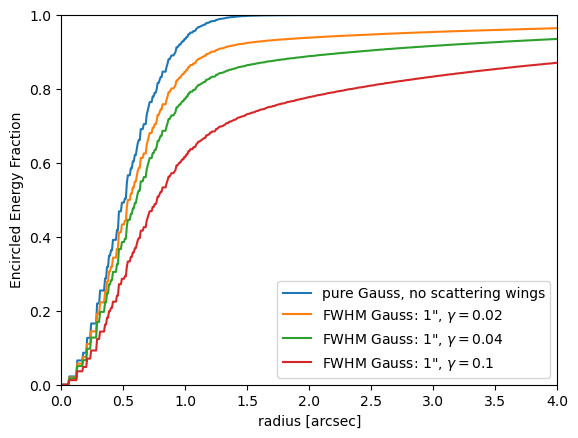

In [13]:
pixel_per_arcsec = 12.5
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, 1, .0, pixel_per_arcsec), rarray),
         label='pure Gauss, no scattering wings')
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, 1, .02, pixel_per_arcsec), rarray),
         label='FWHM Gauss: 1", $\gamma=0.02$')
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, 1, .04, pixel_per_arcsec), rarray),
         label='FWHM Gauss: 1", $\gamma=0.04$')
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, 1, .1, pixel_per_arcsec), rarray),
         label='FWHM Gauss: 1", $\gamma=0.1$')
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.legend()
plt.ylabel('Encircled Energy Fraction')
out = plt.xlabel('radius [arcsec]')

Compare this plot to the Chandra PSF [in Fig 4.6 in the proposer's observatory guide](https://cxc.harvard.edu/proposer/POG/html/chap4.html#tth_sEc4.2.3). I have manually tuned the parameters to get qualitative agreement with the Chandra PSF. In Chandra, the on-axis PSF is $< 0.5"$, while we aim for 1" in AXIS. The figure above is scaled to have the x-axis run from 0 to 4.0", while the figure in the Chandra POG runs from 0 to 2.0". So, the PSFs should look similar if putting the figures on top of each other. 

How do the scattering wings scale if the PSF increases? Well, we don't know exactly, so I've chosen wings that are a little wider than Chandra, just as the core is a little wider, but not twice as much. For example, the green line hits 95% EE at 2 arcsec, similar to the 1.5 keV line in the Chandra POG. That's probably an optimistic assumption, but hopefully good enough for now.

So, I'll generate PSF files with the wings using $\gamma=0.05$ for low energies, $\gamma=0.1$ around 1.5 keV and $\gamma=0.2$ at higher energies. For the Gaussian core of the PSF, a table that Andy Ptak generated (not sure where that comes from) that has some prescription of how the PSF FWHM increases for higher energies and off-axis angles. 

Again, this is no more than an educated guess, and we should not rely on the exact numbers I've chosen here.

In [14]:
def gamma(energy):
    return np.interp(energy, [0.2, 0.5, 2.0, 6.0, 15.0],
                     [0.02, 0.03, 0.04, .1, .1])

In [15]:
def PSF_voigt(n_pix, energy, offaxis, FWHMscale=1):
    '''Currently, only to for energies that match table exactly.
    Could interpolate etc, but SIXTE does that already internally, so 
    no need to do that here.
    '''
    FWHM = np.interp(energy, FWHMtab['energies'], FWHMtab[str(int(offaxis))])
    FWHM *= FWHMscale
    return image_voigt(n_pix, FWHM, gamma(energy))

In [16]:
extnamepattern = re.compile("(?P<energy>[0-9.]+)keV_(?P<offaxis>[0-9.]+)amin")

In [17]:
def make_psf_file(filename, FWHMscale=1):
    hdus = fits.open(input_name)
    for hdu in hdus:
        out = extnamepattern.search(hdu.header['EXTNAME'])
        hdu.data = PSF_voigt(hdu.header['NAXIS1'], 
                             float(out.group('energy')),
                             float(out.group('offaxis')),
                             FWHMscale=FWHMscale)
        hdu.header['HISTORY'] = 'modified by Moritz Guenther'
        hdu.header['HISTORY'] = 'to change the functional shape of the PSF'
        hdu.header['HISTORY'] = 'to include scattering wings'
        hdu.header['VERSION'] = str(datetime.now().date()).replace('-', '') 
        hdu.header['HISTORY'] = f'Version: {datetime.now()}'
        hdu.header['HISTORY'] = f'FWHMscale: {FWHMscale}'
    hdus.writeto(filename, overwrite=True)

I'm making two PSFs: One based on an "about 1 arcsec" PSF and a second one for "about 2 arcsec". I'm assuming that the PSF degrades from one file to the other, because the alignment of the mirror shells is not as good, but the roughness and figure errors (which cause the wings) stay the same, thus, I'm only scaling up the central Gaussian, not the wings.
Since the total PSF is Gaussian core AND wings I need to scale the core by a factor that's a little more than 2 to make the combined width about twice as big.

In [18]:
make_psf_file('axis_psf_v3.1_voigt_1arcsec.fits', FWHMscale=1)
make_psf_file('axis_psf_v3.1_voigt_2arcsec.fits', FWHMscale=2.2)

## How wide should the PSF be?


/var/folders/r7/f0qh27rn207bwwvt3s7v5gh40000gn/T/ipykernel_29128/59060856.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[1].plot(np.log10(hdus[0].data[125, :]))


(-10.0, 0.0)

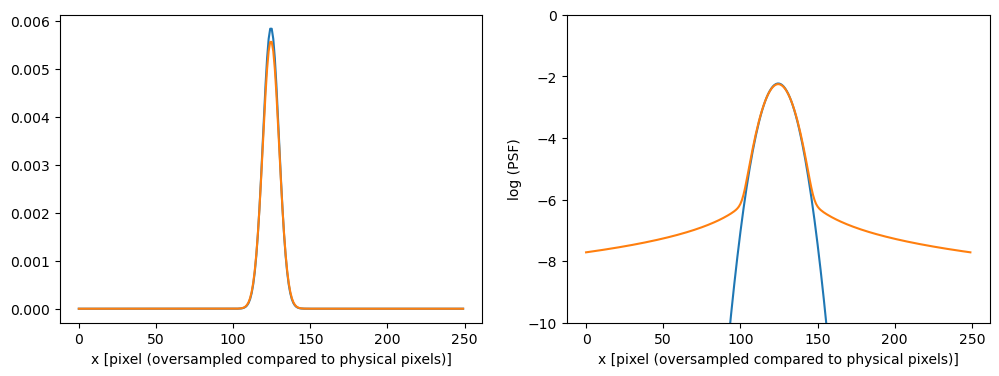

In [19]:
arr = image_voigt(250, 1., 0.001, pixel_per_arcsec=12.5)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(hdus[0].data[125, :])
axes[0].plot(arr[125, :])
axes[1].plot(np.log10(hdus[0].data[125, :]))
axes[1].plot(np.log10(arr[125, :]))
for ax in axes:
    ax.set_xlabel('x [pixel (oversampled compared to physical pixels)]')

axes[1].set_ylabel('PSF')
out = axes[1].set_ylabel('log (PSF)')
axes[1].set_ylim(-10, -0)

Blue is a Gaussian PSF, orange is the new Voigt profile developed here. On the left, the two PSFs are shown on a linear scale and look almost identical except for the normalization in the center. However, in X-rays we often show images on a log scale (right) to bring out fainter features and here differences are stark. 
Here, I'm looking at PSFs in the SIXTE input images which are ideally oversampled compared to the physical pixels of the detector. In this particular case, I made the files 250 pixel wide (not detector pixels, because this file is oversampled, more on that later) and over this scale, the Gaussian PSf drops by > 100 orders of magnitude to essentially 0. However, the Voigt profile has much larger wings. That's a feature not a bug, we specifically chose this profile to describe large scattering wings.

In [20]:
energy = 1
offaxis = 0
FWHMscale = 1

In [30]:
def wing(theta):
    '''Formula from https://cxc.harvard.edu/cal/Hrma/rsrc/Publish/Optics/PSFWings/wing_analysis_rev1b.pdf
    Table 2, using numbers for 1 keV'''
    alpha = 1.972 # Called "gamma" in the table
    theta_0 = 10. #arcsec
    a = 0.748e-5
    c = -0.675e-3
    return a * (theta / theta_0)**(-alpha) * np.exp(c * theta)

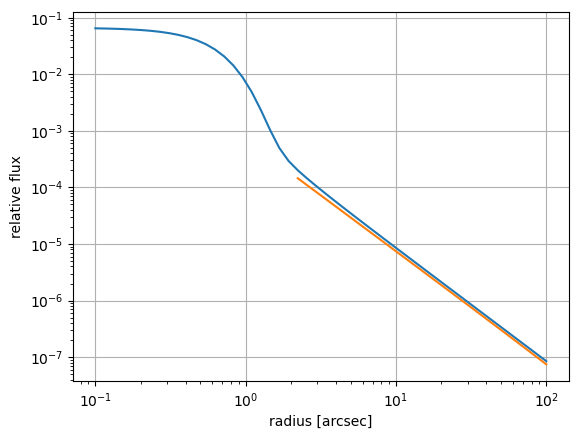

In [32]:
energy = 1
offaxis = 0
FWHMscale = 1

FWHM = np.interp(energy, FWHMtab['energies'], FWHMtab[str(int(offaxis))])
sigma = FWHM / 2.2

r = np.logspace(-1, 2)
plt.loglog(r, voigt_profile(r * pixel_per_arcsec, 
                              sigma * pixel_per_arcsec,
                              gamma(energy) * pixel_per_arcsec))
ind = r > 2
plt.plot(r[ind], wing(r[ind]))
plt.grid(True)
plt.xlabel('radius [arcsec]')
out = plt.ylabel('relative flux')

The blue line shows the PSF parameterization as a Voigt profile that I have chose above for a 1 keV PSF. The orange line shows the measurement of the Chandra scattering wings. The agreement is remarkable; this is partially by accident. The Voigt trends towards a powerlaw decay with exponent -2, which is very close to the measured Chandra value for 1 keV. In Chandra, the slope steepens a bit with energy, but for simplicity, we will not model this here for AXIS, but simply use the same parameterization that we used before. What we do need to change though, is to make PSF files that go out much, much further than just the ~10 arcsec that we generated above. 

At the same time, we need to keep the file size manageable and so we need to compromise in other ways: We are now going to write PSF files with a larger spatial extent on the detector, but less oversampling (larger pixel scale) and with fewer points in energy and off-axis angle.

In [23]:
def update_header(hdu, energy, offaxis_in_arcmin, CDELT):
    header = hdu.header
    # In this case, it's easy to just write the WCS by hand, so we do that
    header['CTYPE1']  = ('DETX', 'detector coordinate system')
    header['CTYPE2']  = ('DETY', 'detector coordinate system')                    
    header['HDUCLASS']= ('OGIP', 'Extension is OGIP defined')                     
    header['HDUDOC']  = 'CAL/GEN/92-020'
    header['HDUVERS'] = '1.0.0   '            
    header['HDUCLAS1']= 'Image   '                                                            
    header['HDUCLAS2']= 'PSF     '                                                            
    header['HDUCLAS3']= 'PREDICTED'                                                           
    header['HDUCLAS4']= 'NET     '                                                            
    header['CUNIT1']  = 'm       '                                                            
    header['CUNIT2']  = 'm       '                                                            
    header['CRPIX1']  = hdu.data.shape[0] / 2   
    header['CRPIX2']  = hdu.data.shape[1] / 2                     
    header['CRVAL1']  = 0.                        
    header['CRVAL2']  = 0.                     
    header['CDELT1']  = (CDELT, 'X axis increment')                             
    header['CDELT2']  = (CDELT, 'Y axis increment')                              
    header['BACKGRND']= (0., 'background count rate per pixel')              
    header['TELESCOP']= 'AXIS    '                         
    header['INSTRUME']= '        '                        
    header['FILTER']  = 'NONE    '                                
    header['ORIGIN']  = 'MIT    '  
    header['CREATOR'] = 'Guenther'                                                         
    header['ENERGY']  = (energy * 1000, 'photon energy for the PSF generation in [eV]')  
    header['THETA']   = (offaxis_in_arcmin, 'off-axis angle in [arc min]')                   
    header['PHI']     = (0., 'azimuthal angle in [degree]')                     
    header['EXTNAME'] = f'{energy:3.1f}keV_{offaxis_in_arcmin:4.2f}amin'                                                     
    header['VERSION'] = str(datetime.now().date()).replace('-', '')                                                         
    header['HISTORY'] = 'produced by H. Moritz Guenther at MIT. Core of PSF is based on data provided by Thomas Dauser and Andy Ptak. Wings are made to match Chandra.'
    header['HISTORY'] = 'See https://github.com/hamogu/AXIS/blob/main/PSF/Generate_PSF_for_SIXTE.ipynb for details.'

In [24]:
def make_PSFfile_voigt_from_scratch(pixel_per_arcsec=3, npix=2500, FWHMscale=1,
                                    offaxis_in_arcmin=[0., 4., 8., 16.],
                                    energy=[.2, 2., 8., 15.]):
    nx, ny = npix, npix


    CDELT = 9 * u.m * np.sin(1 * u.arcsec) / pixel_per_arcsec
    dx, dy = np.mgrid[0: nx, 0: ny]
    dx = dx - nx / 2. + 0.5
    dy = dy - ny / 2. + 0.5
    radius = np.sqrt(dx**2 + dy**2)

    newhdus = []
    for o in offaxis_in_arcmin:
        for e in energy:
            FWHM = np.interp(e, FWHMtab['energies'], 
                            FWHMtab[str(int(o))])
            FWHM *= FWHMscale
            sigma = FWHM / 2.355
            
            arr = voigt_profile(radius * pixel_per_arcsec, 
                                sigma * pixel_per_arcsec,
                                gamma(e) * pixel_per_arcsec)
            if len(newhdus) == 0:
                image_hdu = fits.PrimaryHDU(arr)
            else:
                image_hdu = fits.ImageHDU(arr)
            update_header(image_hdu, e, o, CDELT.value)
            newhdus.append(image_hdu)

    return fits.HDUList(newhdus)


So, I’ve decided to offer two version of my PSF file for simulations:

- A big version that is big enough so that a source in the center of the FOV actually shows wings all the way out so that we can properly qualify how much this hampers our ability to detect faint objects. The downside is that this will require to run SIXTE with a very big input file and the binning of the PSF input will be be such that details in the code of the PSF are washed out.
- A smaller version, that has more detail in the center of the PSF, but cuts off the wings. This version is appropriate if none of the sources simulated are bright enough for the wings at large distances to matter.

In [28]:
make_PSFfile_voigt_from_scratch(pixel_per_arcsec=4, npix=6000, FWHMscale=1,
                                offaxis_in_arcmin=[0., 16.],
                                energy=[.2, 15.]).writeto('axis_psf_v4_voigt_1arcsec_big.fits', checksum=True, overwrite=True)
make_PSFfile_voigt_from_scratch(pixel_per_arcsec=2, npix=6000, FWHMscale=2,
                                offaxis_in_arcmin=[0., 16.],
                                energy=[.2, 15.]).writeto('axis_psf_v4_voigt_2arcsec_big.fits', checksum=True, overwrite=True)

In [26]:
make_PSFfile_voigt_from_scratch(pixel_per_arcsec=10, npix=1000, FWHMscale=1,
                                offaxis_in_arcmin=[0., 8., 16.],
                                energy=[.2, 6., 15.]).writeto('axis_psf_v4_voigt_1arcsec_small.fits', checksum=True, overwrite=True)
make_PSFfile_voigt_from_scratch(pixel_per_arcsec=10, npix=1000, FWHMscale=2,
                                offaxis_in_arcmin=[0., 8., 16.],
                                energy=[.2, 6., 15.]).writeto('axis_psf_v4_voigt_2arcsec_small.fits', checksum=True, overwrite=True)

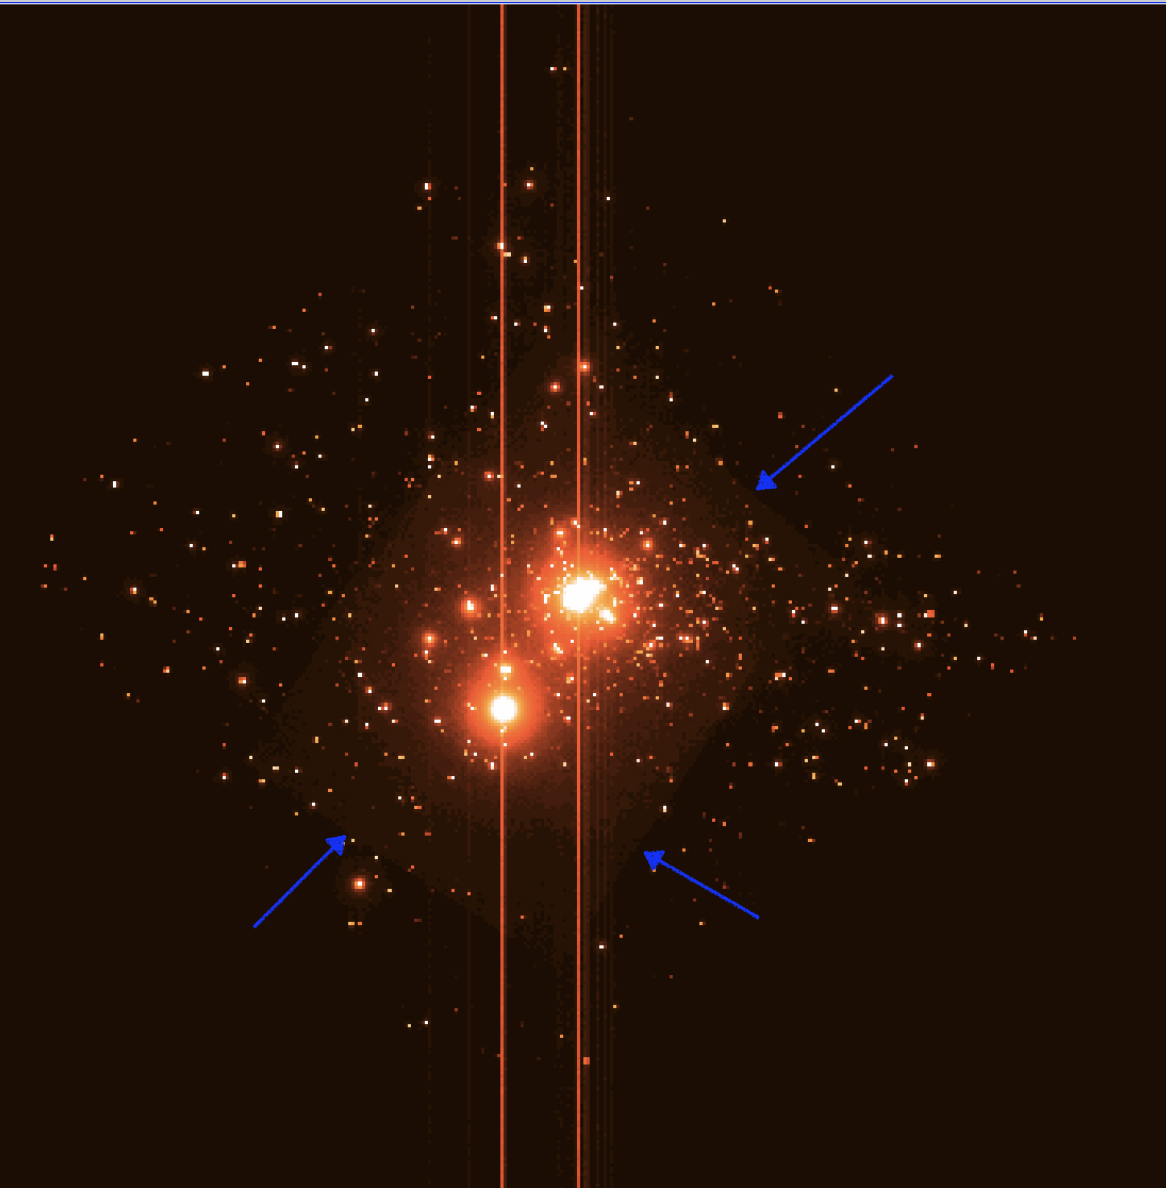

In [27]:
from IPython.display import Image
Image("ONC_PSF_too_small.png")